In [1]:
import pathlib
import cv2
import numpy as np
import time
import itertools

from collections import Counter

from tqdm import tqdm

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim


def get_index_of_file(file_path, index):
    list_of_files = sorted(pathlib.Path(file_path).iterdir())
    f = list_of_files[index]
    try:
        f = int(f.stem)
    except ValueError:
        for current_file in list_of_files:
            if current_file.name[0] != '.':
                f = current_file
                break
        f = int(f.stem)
    return f
    
class ImageGrammarProcessor():
    
    def __init__(self, equalize=True):
        scales = np.array(0.01)
        #scales = np.append(scales, np.arange(0.01,0.05,0.02))
        scales = np.append(scales, np.arange(0.001,0.01,0.002))
        self.scales = scales
        self.equalize = equalize        
        
    def calculate_t_frames(self, file_path, scaling=None, exploring=True):
        img_arr = None
        for current_file in sorted(pathlib.Path(file_path).iterdir()):
            # Need to handle case when image file name ._005.jpg appears
            # Found in .../photos_processed/2019-02-27
            if current_file.name[0] == '.':
                continue
                
            file_string = str(current_file)
            img = cv2.imread(file_string, flags=cv2.IMREAD_GRAYSCALE)
            if self.equalize:
                img = cv2.equalizeHist(img)

            if scaling is not None:
                img = cv2.resize(img, None,
                                 fx=scaling, fy=scaling, 
                                 interpolation=cv2.INTER_AREA)
            if img_arr is None:
                height, width = np.shape(img)[:2]
                flat_d = height * width
                img_arr = np.zeros((flat_d,0))

            img_1d = np.expand_dims(np.ravel(img), axis=1)
            img_arr = np.append(img_arr, img_1d, axis=1)

        img_diff = np.diff(img_arr)
        img_norms = np.linalg.norm(img_diff, axis=0)

        avg = np.mean(img_norms)
        std = np.std(img_norms)
        transition_frames = np.argwhere(img_norms > avg).flatten()
        transition_values = img_norms[img_norms > avg]
        transition_frames_std = np.argwhere(img_norms > avg+std).flatten()
        transition_values_std = img_norms[img_norms > avg+std]

        return (transition_frames, transition_values, 
                avg, std,
                transition_frames_std, transition_values_std)
    
    def get_files_list(self, file_path, transition_frames):
        files_list = list()
        start_int = get_index_of_file(file_path, 0)
        #start_int = int(first_file.stem)
        for i in transition_frames:
            files_list.append(str(pathlib.Path(file_path)
                          .joinpath('{:03d}.jpg'.format(i+start_int))))
        return files_list

    
    def display_images(self, files_list):
        fig = plt.figure(1, (14., 10.))
        img_per_row = 7
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(len(files_list)//img_per_row+1, img_per_row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
        #for i,f in tqdm(enumerate(files_list)):
        for i,f in enumerate(files_list):
            img = cv2.imread(f, flags=cv2.IMREAD_GRAYSCALE)
            if self.equalize:
                img = cv2.equalizeHist(img)
            img = img_as_float(img)
            grid[i].axis('off')
            grid[i].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
        return grid
    
    
    def run(self, file_path, verbose=0):
        scaling_options = self.scales
        t_frames_list = list()
        std_frames_list = list()
        for scaling in scaling_options:
            (transition_frames, transition_values, 
             avg, std,
             transition_frames_std, transition_values_std) = self.calculate_t_frames(file_path, scaling)
            files_list = self.get_files_list(file_path, transition_frames)
            std_files_list = self.get_files_list(file_path, transition_frames_std)

            t_frames_list.append(transition_frames)
            std_frames_list.append(transition_frames_std)
            if verbose > 0:
                self.display_images(files_list)
                plt.show()
                print("Count: {}\n".format(len(transition_frames)))
                time.sleep(1)
                self.display_images(std_files_list)
                plt.show()
                print("Count: {}\n".format(len(transition_frames_std)))
        if verbose > 1:
            print("T Frames:\n{} \n\nSTD Frames:\n{}".format(t_frames_list, std_frames_list))

        return (t_frames_list, std_frames_list)
    
    
    def plot_counts(self, frames_list):
        for scale, t_frames in zip(self.scales, frames_list):
            scale_label = list(itertools.repeat(scale, len(t_frames)))
            plt.plot(t_frames, scale_label, ".")
        plt.show()

    def get_counts(self, frames_list):
        counts = Counter()
        for t_frames in frames_list:
            counts += Counter(t_frames)
        c = dict(counts)
        d = [k for k,v in c.items() if v > 4]
        return (d)
        
    def get_sift_frames(self, file_path, verbose=0):
        print("FILE PATH: {}".format(file_path))
        t_frames_list, std_frames_list = self.run(file_path, verbose=verbose)
        self.plot_counts(t_frames_list)
        self.plot_counts(std_frames_list)
        sift_t = self.get_counts(t_frames_list)
        sift_std = self.get_counts(std_frames_list)
        print("Sift_t: {}|{}\nSift_std: {}|{}\n".format(len(sift_t), sift_t, 
                                                        len(sift_std), sift_std))

        return (sift_t, sift_std)

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-18


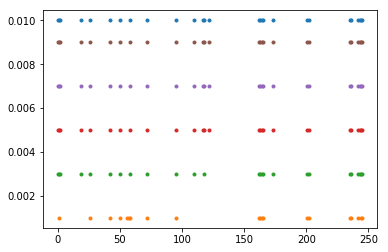

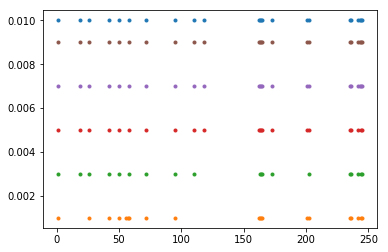

Sift_t: 25|[0, 1, 2, 19, 26, 42, 50, 58, 72, 95, 110, 118, 162, 163, 164, 165, 173, 201, 202, 235, 236, 242, 243, 244, 245]
Sift_std: 21|[1, 19, 26, 42, 50, 58, 72, 95, 110, 162, 163, 164, 165, 173, 201, 202, 235, 236, 242, 244, 245]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-20


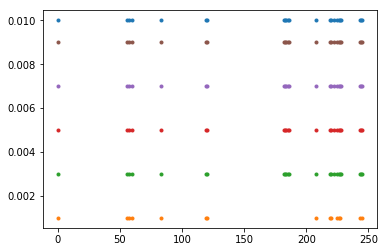

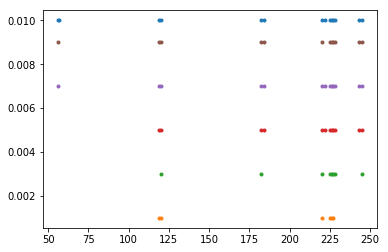

Sift_t: 23|[0, 56, 57, 60, 83, 119, 120, 182, 183, 184, 185, 186, 208, 219, 220, 222, 225, 226, 227, 228, 243, 244, 245]
Sift_std: 9|[119, 120, 182, 220, 225, 226, 227, 228, 245]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-21


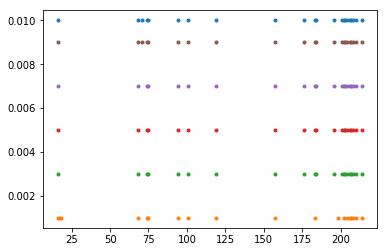

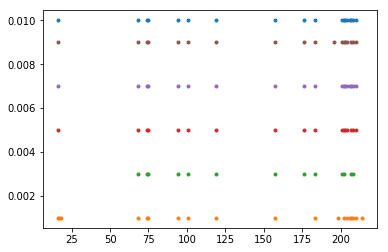

Sift_t: 21|[16, 68, 74, 75, 94, 101, 119, 157, 176, 183, 184, 196, 201, 202, 203, 204, 206, 207, 208, 210, 214]
Sift_std: 16|[16, 68, 74, 75, 94, 101, 119, 157, 176, 183, 201, 202, 204, 207, 208, 210]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-22


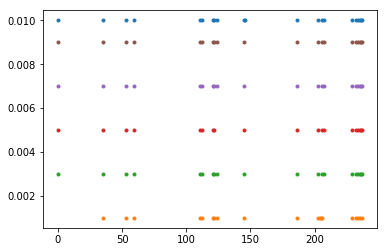

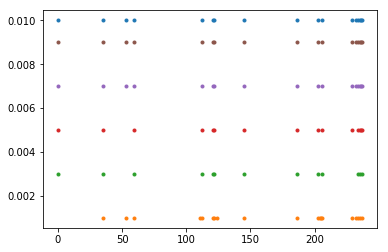

Sift_t: 20|[0, 35, 53, 59, 111, 112, 121, 122, 124, 145, 186, 203, 206, 207, 229, 232, 234, 235, 236, 237]
Sift_std: 14|[0, 35, 59, 112, 121, 122, 145, 186, 203, 206, 229, 234, 235, 237]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-25


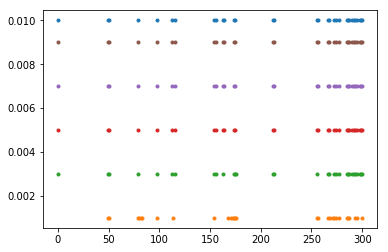

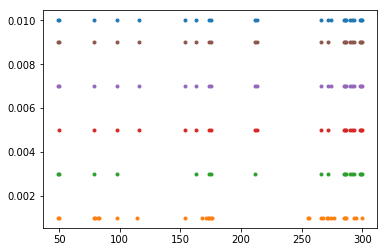

Sift_t: 31|[0, 49, 50, 79, 98, 113, 116, 154, 156, 163, 174, 175, 212, 213, 255, 256, 266, 267, 272, 274, 277, 285, 286, 287, 290, 292, 293, 295, 298, 299, 300]
Sift_std: 20|[49, 50, 79, 98, 154, 163, 174, 175, 212, 266, 272, 285, 286, 287, 290, 292, 293, 298, 299, 300]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-26


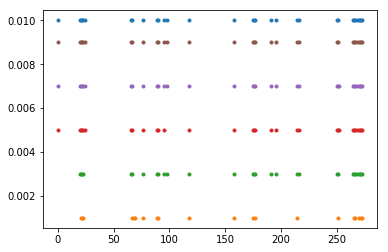

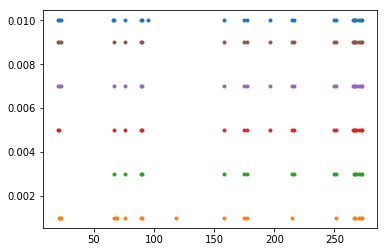

Sift_t: 29|[20, 21, 22, 23, 66, 67, 76, 89, 90, 95, 118, 158, 175, 176, 177, 191, 196, 215, 216, 250, 251, 265, 266, 267, 268, 270, 271, 272, 273]
Sift_std: 18|[21, 67, 76, 89, 90, 158, 175, 177, 215, 216, 250, 251, 266, 267, 268, 270, 272, 273]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-27


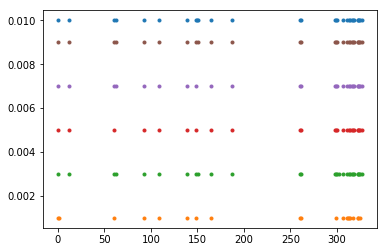

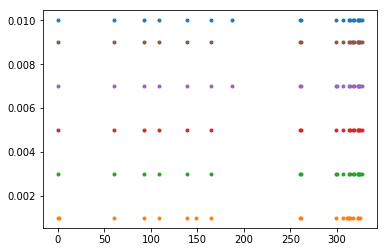

Sift_t: 26|[0, 12, 60, 93, 109, 139, 148, 165, 187, 260, 261, 298, 299, 300, 306, 311, 313, 314, 316, 317, 318, 322, 323, 324, 325, 327]
Sift_std: 19|[0, 60, 93, 109, 139, 165, 260, 261, 299, 306, 313, 314, 317, 318, 322, 323, 324, 325, 327]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-02-28


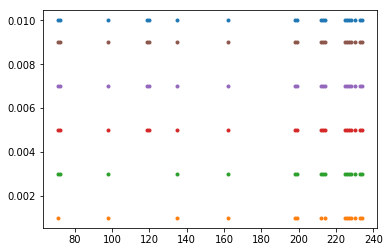

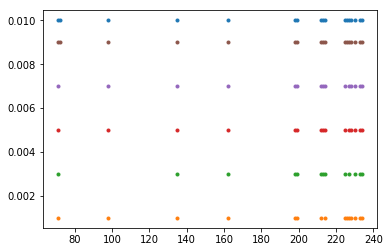

Sift_t: 17|[71, 72, 98, 135, 162, 198, 199, 212, 213, 214, 225, 226, 227, 228, 230, 233, 234]
Sift_std: 15|[71, 98, 135, 162, 198, 199, 212, 213, 214, 225, 227, 228, 230, 233, 234]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-01


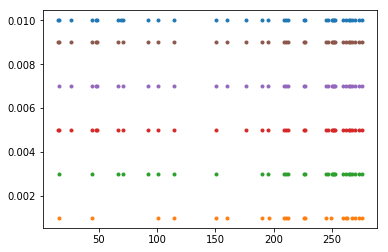

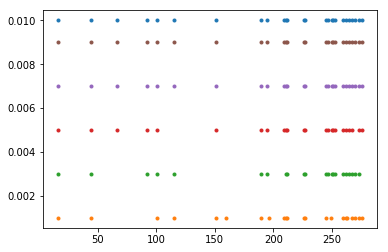

Sift_t: 29|[16, 44, 67, 71, 92, 101, 115, 151, 190, 195, 209, 211, 212, 226, 227, 245, 247, 250, 251, 252, 253, 260, 262, 265, 266, 267, 270, 273, 276]
Sift_std: 25|[16, 44, 92, 101, 115, 151, 190, 195, 209, 211, 212, 226, 227, 245, 247, 250, 251, 253, 260, 262, 265, 267, 270, 273, 276]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-03


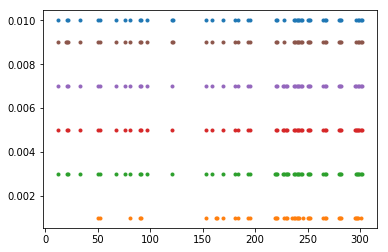

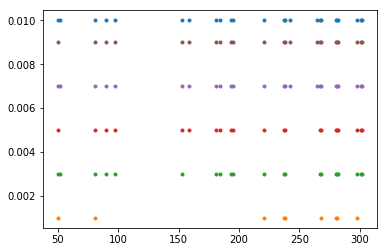

Sift_t: 44|[12, 21, 22, 33, 50, 52, 67, 76, 81, 90, 91, 97, 121, 153, 159, 169, 181, 184, 193, 195, 220, 221, 228, 237, 238, 240, 241, 242, 244, 245, 250, 251, 252, 265, 267, 268, 280, 281, 282, 296, 298, 299, 301, 302]
Sift_std: 20|[50, 81, 90, 97, 153, 181, 184, 193, 195, 221, 237, 238, 267, 268, 280, 281, 282, 298, 301, 302]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-04


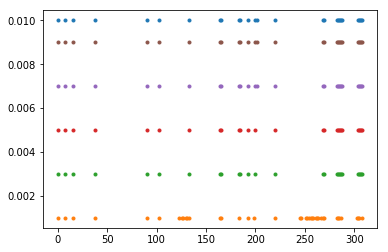

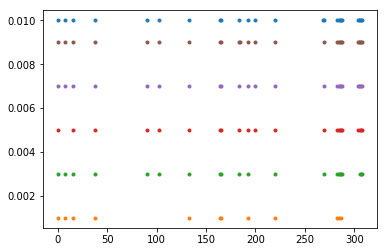

Sift_t: 27|[0, 7, 15, 38, 90, 102, 133, 164, 165, 183, 184, 192, 200, 220, 268, 269, 283, 284, 285, 286, 287, 288, 304, 305, 306, 307, 308]
Sift_std: 21|[0, 7, 15, 38, 90, 102, 133, 164, 165, 183, 192, 220, 269, 283, 285, 286, 287, 288, 306, 307, 308]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-05


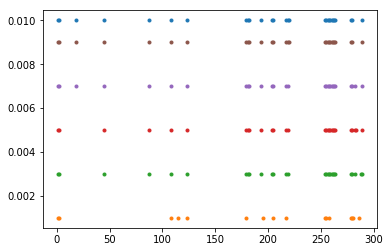

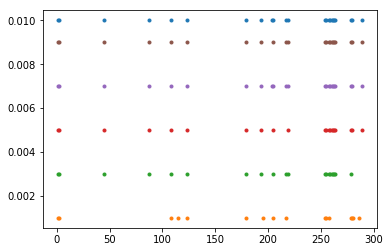

Sift_t: 26|[1, 2, 45, 87, 108, 123, 179, 181, 182, 193, 204, 205, 217, 219, 254, 255, 257, 258, 259, 260, 261, 262, 263, 278, 279, 289]
Sift_std: 21|[1, 2, 45, 87, 108, 123, 179, 193, 205, 217, 219, 254, 255, 258, 259, 260, 261, 262, 263, 278, 279]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-06


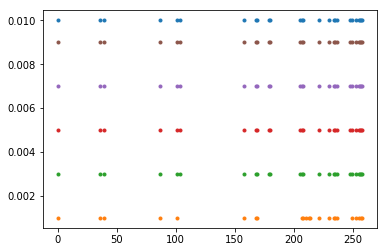

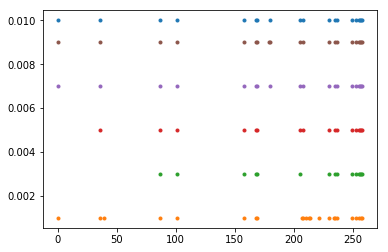

Sift_t: 26|[0, 36, 39, 87, 101, 104, 158, 168, 169, 179, 180, 205, 207, 208, 221, 230, 234, 235, 237, 248, 249, 253, 255, 256, 257, 258]
Sift_std: 17|[36, 87, 101, 158, 168, 169, 205, 208, 230, 235, 237, 249, 253, 255, 256, 257, 258]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-07


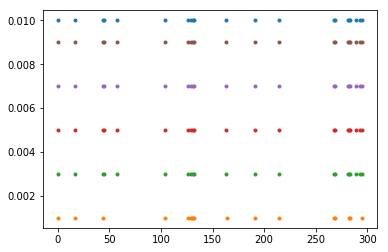

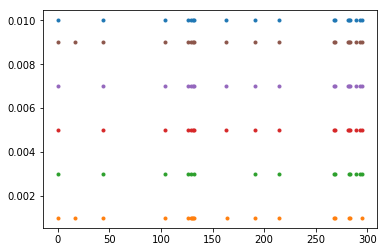

Sift_t: 21|[0, 17, 44, 45, 57, 104, 126, 129, 131, 132, 163, 191, 214, 268, 269, 281, 282, 283, 289, 293, 295]
Sift_std: 16|[0, 44, 104, 126, 129, 131, 132, 191, 214, 268, 269, 282, 283, 289, 293, 295]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-08


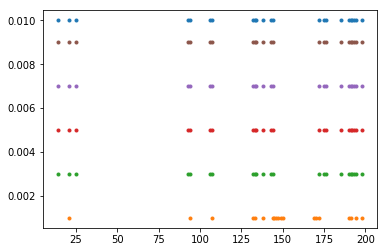

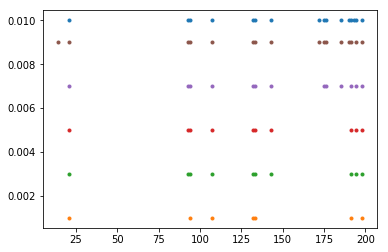

Sift_t: 23|[14, 21, 25, 93, 94, 106, 107, 132, 133, 134, 138, 143, 144, 172, 175, 176, 185, 190, 191, 192, 193, 194, 198]
Sift_std: 10|[21, 93, 94, 107, 132, 133, 143, 191, 194, 198]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-10


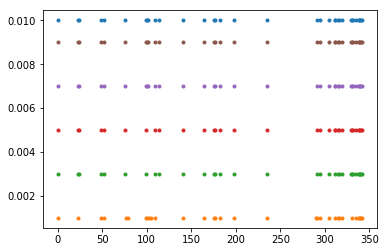

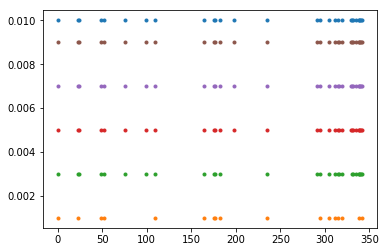

Sift_t: 32|[0, 23, 24, 48, 52, 76, 99, 109, 114, 141, 164, 175, 177, 182, 198, 235, 291, 295, 305, 312, 315, 316, 319, 330, 331, 332, 335, 338, 339, 340, 341, 342]
Sift_std: 27|[0, 23, 24, 48, 52, 76, 99, 109, 164, 175, 177, 182, 235, 291, 295, 305, 312, 315, 319, 331, 332, 335, 338, 339, 340, 341, 342]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-11


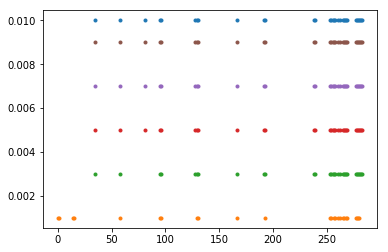

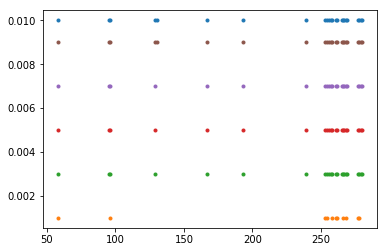

Sift_t: 31|[35, 58, 95, 96, 128, 129, 130, 167, 192, 193, 238, 239, 253, 254, 256, 257, 258, 261, 262, 265, 266, 267, 268, 269, 277, 278, 279, 280, 281, 282, 283]
Sift_std: 23|[58, 95, 96, 129, 167, 193, 239, 253, 254, 256, 257, 258, 261, 262, 265, 266, 267, 268, 269, 277, 278, 279, 280]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-12


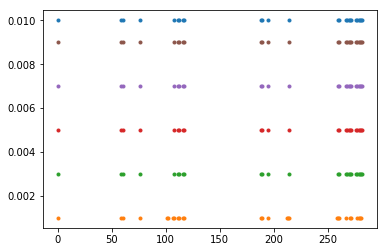

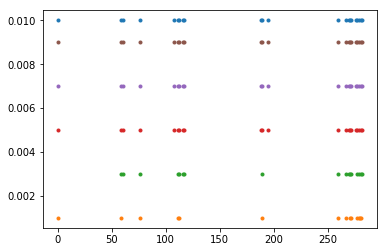

Sift_t: 26|[0, 59, 60, 76, 108, 111, 112, 116, 117, 188, 189, 195, 214, 260, 261, 267, 268, 270, 271, 272, 276, 277, 279, 280, 281, 282]
Sift_std: 18|[0, 59, 60, 76, 111, 112, 116, 117, 189, 260, 267, 270, 271, 272, 277, 279, 281, 282]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-13


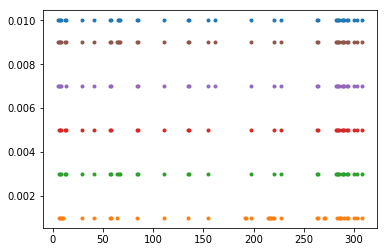

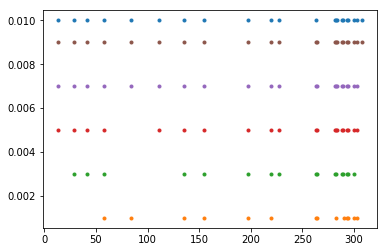

Sift_t: 31|[6, 7, 8, 13, 29, 41, 57, 58, 84, 85, 111, 135, 136, 155, 197, 220, 227, 263, 264, 282, 283, 284, 285, 288, 289, 290, 293, 294, 300, 303, 308]
Sift_std: 18|[29, 41, 58, 135, 155, 197, 220, 227, 263, 282, 283, 288, 289, 293, 294, 300, 303, 264]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-14


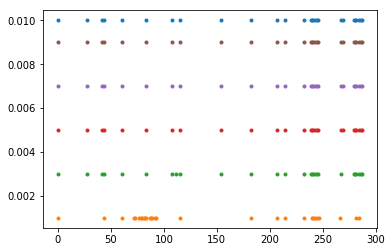

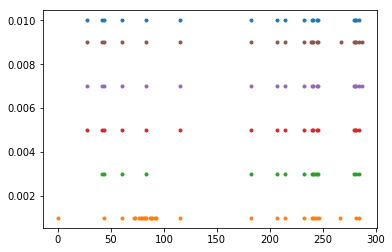

Sift_t: 26|[0, 28, 42, 44, 61, 83, 108, 115, 154, 182, 207, 214, 232, 239, 240, 241, 243, 244, 245, 267, 279, 280, 281, 284, 286, 287]
Sift_std: 16|[42, 44, 61, 83, 115, 182, 207, 214, 232, 240, 241, 244, 245, 279, 281, 284]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-15


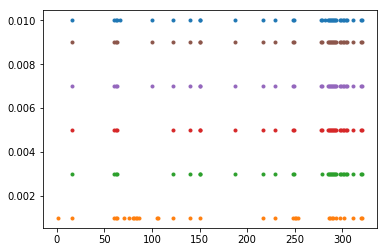

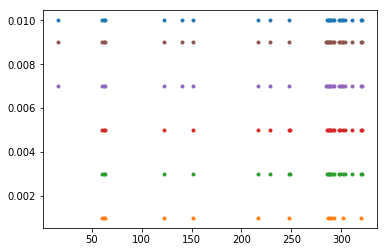

Sift_t: 32|[16, 60, 62, 63, 122, 140, 150, 151, 187, 217, 229, 248, 249, 279, 285, 286, 287, 288, 289, 290, 291, 292, 293, 298, 299, 301, 302, 304, 305, 311, 320, 321]
Sift_std: 22|[60, 62, 63, 122, 151, 217, 229, 248, 286, 287, 288, 289, 290, 292, 293, 298, 299, 302, 304, 311, 320, 321]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-17


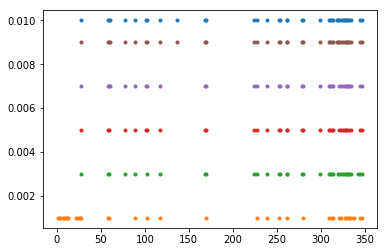

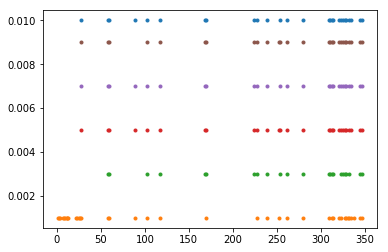

Sift_t: 34|[27, 58, 59, 77, 89, 102, 117, 168, 170, 224, 227, 239, 252, 254, 261, 262, 279, 280, 299, 309, 310, 313, 314, 321, 323, 325, 328, 329, 330, 331, 332, 334, 345, 347]
Sift_std: 26|[27, 58, 59, 102, 117, 168, 170, 224, 227, 239, 254, 262, 280, 309, 310, 313, 314, 321, 323, 325, 328, 329, 332, 334, 345, 347]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-19


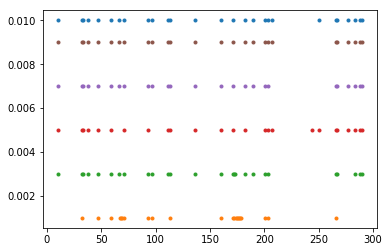

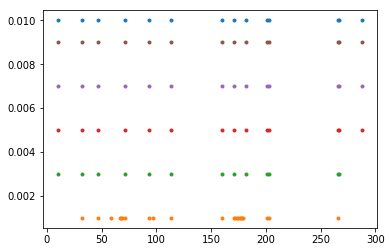

Sift_t: 22|[10, 32, 33, 38, 47, 59, 71, 93, 97, 111, 113, 136, 160, 171, 182, 201, 203, 266, 267, 283, 288, 290]
Sift_std: 13|[10, 32, 47, 71, 93, 113, 160, 171, 182, 201, 203, 266, 267]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-22


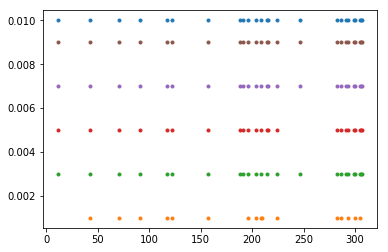

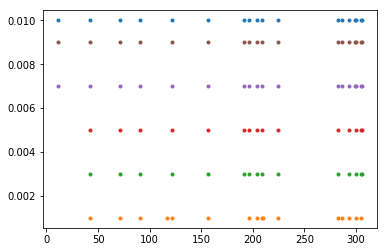

Sift_t: 23|[11, 42, 71, 91, 117, 122, 157, 188, 191, 196, 204, 209, 214, 224, 283, 286, 291, 293, 299, 300, 305, 306, 307]
Sift_std: 15|[42, 71, 91, 122, 157, 191, 196, 204, 209, 224, 283, 293, 300, 305, 306]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-23


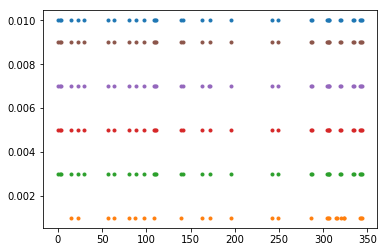

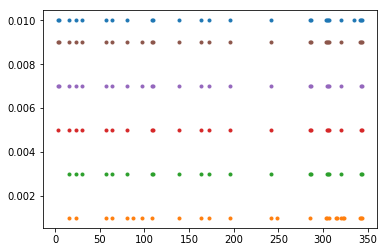

Sift_t: 34|[0, 3, 4, 15, 23, 30, 57, 64, 81, 88, 97, 109, 110, 111, 139, 141, 163, 172, 196, 242, 249, 286, 287, 304, 305, 306, 307, 319, 320, 334, 335, 342, 343, 344]
Sift_std: 21|[15, 23, 30, 57, 64, 81, 109, 110, 139, 163, 172, 196, 242, 286, 287, 305, 306, 307, 320, 343, 344]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-24


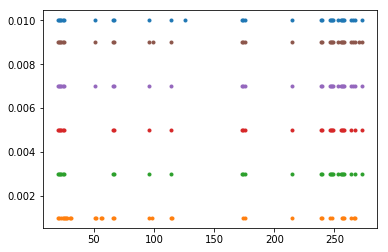

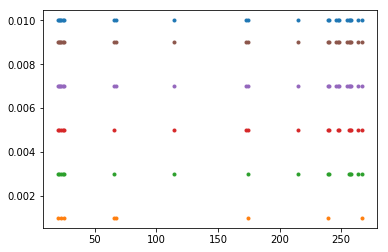

Sift_t: 27|[20, 21, 22, 23, 24, 25, 66, 67, 96, 114, 173, 174, 176, 215, 239, 240, 246, 247, 248, 249, 255, 256, 257, 258, 264, 267, 273]
Sift_std: 16|[20, 21, 23, 24, 25, 66, 114, 174, 215, 239, 240, 256, 257, 258, 264, 267]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-25


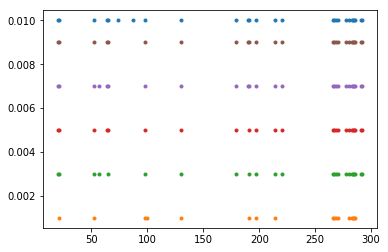

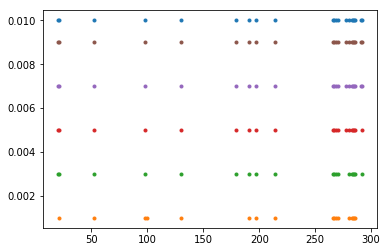

Sift_t: 23|[20, 21, 52, 65, 98, 130, 179, 191, 197, 214, 220, 266, 267, 269, 270, 278, 280, 283, 284, 285, 286, 291, 292]
Sift_std: 19|[20, 21, 52, 98, 130, 179, 191, 197, 214, 266, 267, 269, 270, 280, 283, 284, 285, 286, 292]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-26


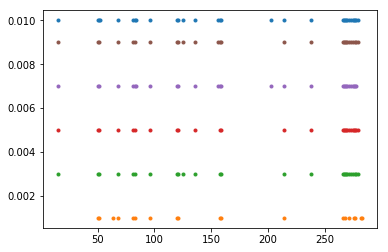

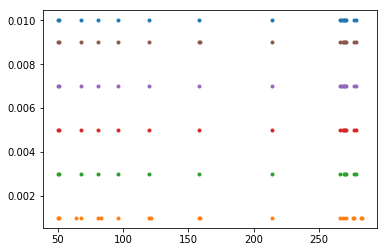

Sift_t: 24|[15, 50, 51, 68, 81, 83, 96, 120, 121, 136, 158, 159, 214, 238, 266, 267, 268, 269, 270, 271, 273, 275, 277, 278]
Sift_std: 15|[50, 51, 68, 81, 96, 120, 158, 214, 266, 268, 269, 270, 271, 277, 278]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-27


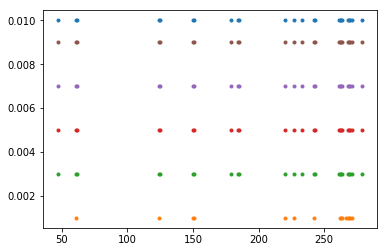

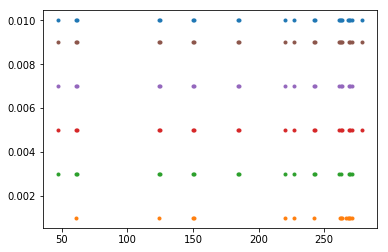

Sift_t: 24|[47, 61, 62, 124, 125, 150, 151, 179, 184, 185, 220, 227, 233, 242, 243, 261, 262, 263, 264, 268, 269, 270, 271, 279]
Sift_std: 19|[47, 61, 62, 124, 125, 150, 151, 184, 185, 220, 227, 242, 243, 261, 263, 264, 269, 270, 271]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-29


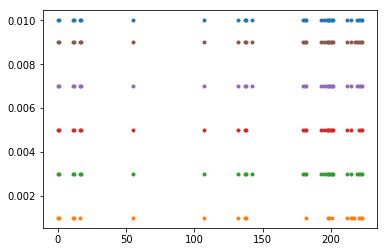

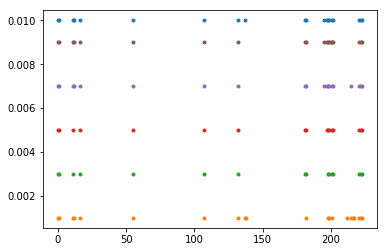

Sift_t: 27|[0, 1, 11, 12, 16, 17, 55, 107, 132, 137, 138, 180, 181, 182, 193, 195, 197, 198, 199, 200, 201, 202, 212, 215, 221, 222, 223]
Sift_std: 16|[0, 1, 11, 16, 55, 107, 132, 181, 182, 198, 199, 201, 202, 221, 222, 223]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-30


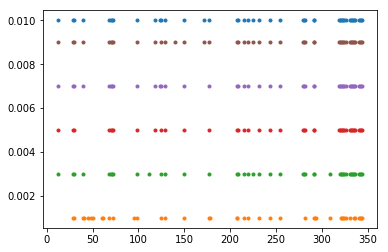

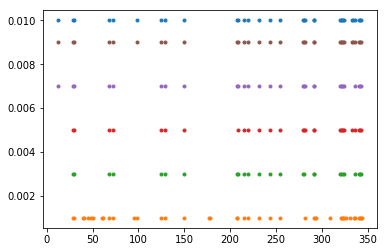

Sift_t: 41|[12, 29, 30, 40, 68, 70, 71, 72, 98, 125, 129, 150, 177, 208, 209, 215, 220, 231, 244, 254, 280, 281, 282, 291, 292, 320, 321, 322, 323, 324, 326, 331, 332, 333, 334, 335, 336, 341, 342, 343, 344]
Sift_std: 28|[29, 30, 68, 72, 125, 129, 150, 208, 209, 215, 220, 231, 244, 254, 280, 281, 282, 291, 292, 320, 321, 322, 323, 324, 336, 341, 342, 343]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-03-31


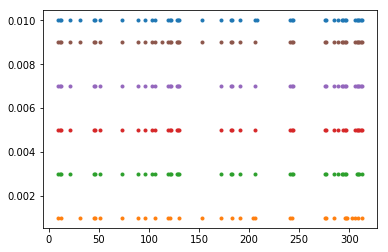

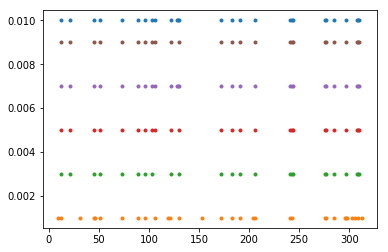

Sift_t: 38|[9, 11, 12, 21, 45, 46, 51, 73, 89, 96, 103, 106, 119, 121, 122, 128, 129, 130, 172, 182, 183, 191, 206, 241, 243, 244, 276, 277, 285, 289, 294, 296, 297, 306, 308, 309, 310, 313]
Sift_std: 25|[12, 21, 45, 51, 73, 89, 96, 103, 106, 122, 130, 172, 183, 191, 206, 241, 243, 244, 276, 277, 285, 297, 308, 309, 310]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-01


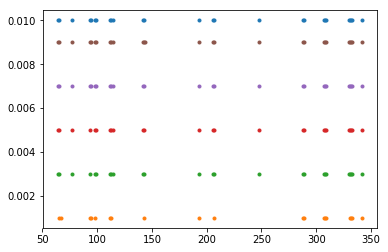

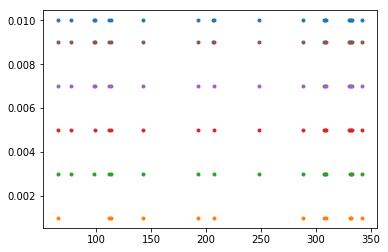

Sift_t: 25|[64, 65, 77, 93, 98, 99, 112, 113, 114, 142, 143, 193, 206, 207, 248, 288, 289, 307, 308, 309, 330, 331, 332, 333, 342]
Sift_std: 16|[65, 77, 112, 113, 143, 193, 207, 248, 288, 307, 308, 309, 331, 332, 333, 342]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-02


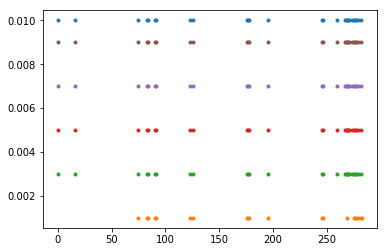

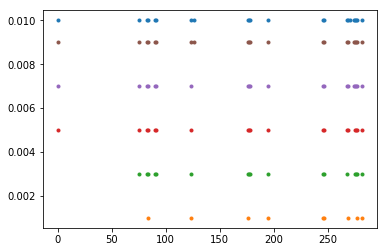

Sift_t: 27|[0, 16, 75, 83, 84, 90, 91, 123, 126, 176, 177, 178, 195, 246, 247, 260, 267, 268, 269, 270, 271, 274, 275, 276, 277, 279, 282]
Sift_std: 18|[75, 83, 84, 90, 91, 123, 176, 177, 178, 195, 246, 247, 268, 269, 275, 276, 277, 282]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-03


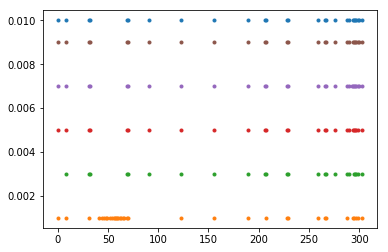

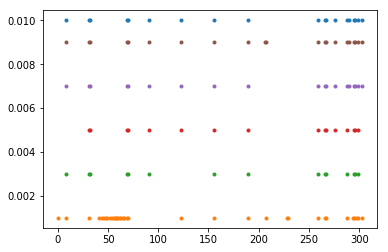

Sift_t: 26|[0, 8, 31, 32, 69, 70, 91, 123, 156, 189, 206, 207, 228, 229, 259, 266, 267, 276, 288, 290, 294, 295, 296, 297, 299, 303]
Sift_std: 16|[8, 31, 32, 69, 70, 91, 123, 156, 189, 259, 266, 267, 288, 295, 296, 299]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-04


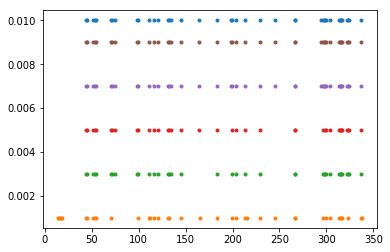

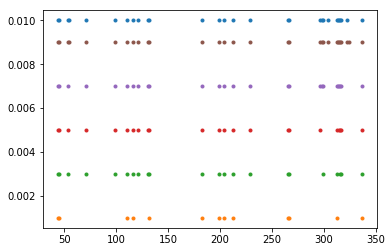

Sift_t: 37|[44, 45, 52, 54, 55, 71, 72, 75, 98, 99, 111, 116, 121, 131, 132, 134, 145, 183, 199, 204, 213, 229, 266, 267, 296, 298, 299, 304, 313, 314, 315, 316, 317, 322, 323, 324, 337]
Sift_std: 21|[44, 45, 54, 71, 99, 111, 116, 121, 131, 132, 183, 199, 204, 213, 229, 266, 267, 313, 316, 317, 337]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-06


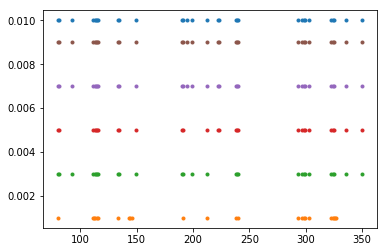

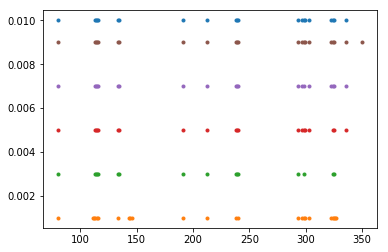

Sift_t: 26|[80, 81, 111, 113, 114, 115, 116, 133, 134, 149, 190, 191, 212, 238, 239, 240, 293, 297, 298, 299, 303, 322, 324, 325, 336, 350]
Sift_std: 18|[80, 113, 114, 115, 116, 133, 134, 191, 212, 238, 239, 240, 293, 297, 298, 303, 324, 325]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-07


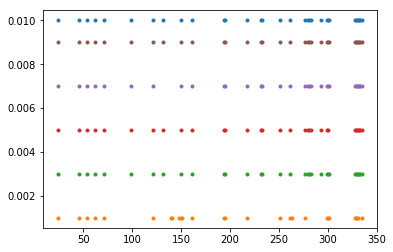

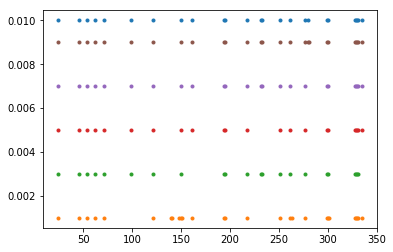

Sift_t: 31|[24, 46, 54, 62, 71, 99, 121, 150, 161, 194, 195, 217, 232, 233, 251, 261, 277, 280, 281, 283, 293, 299, 300, 301, 328, 329, 330, 331, 332, 333, 335]
Sift_std: 22|[24, 46, 54, 62, 71, 99, 121, 150, 161, 194, 195, 217, 251, 261, 277, 299, 300, 328, 329, 330, 331, 335]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-08


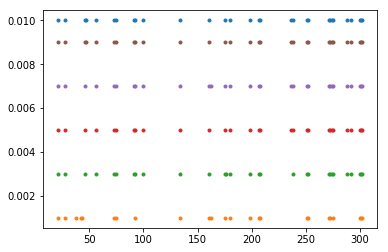

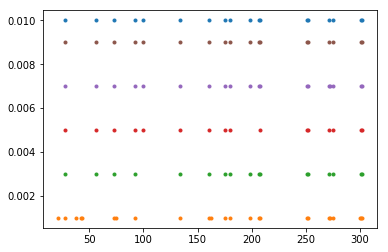

Sift_t: 28|[21, 28, 46, 56, 73, 75, 91, 92, 100, 134, 161, 175, 180, 198, 207, 208, 238, 251, 252, 271, 272, 274, 275, 288, 292, 300, 301, 302]
Sift_std: 17|[28, 56, 73, 92, 134, 161, 175, 180, 198, 207, 208, 251, 252, 271, 275, 301, 302]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-09


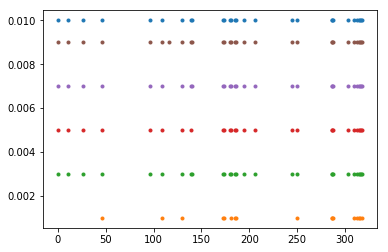

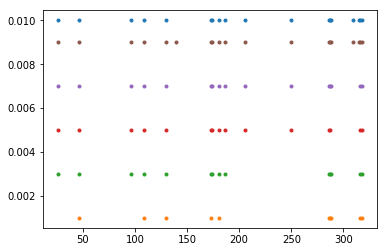

Sift_t: 28|[0, 11, 26, 46, 96, 109, 130, 139, 173, 174, 180, 181, 185, 186, 195, 206, 245, 250, 286, 287, 288, 303, 309, 313, 315, 316, 317, 318]
Sift_std: 14|[26, 46, 96, 109, 130, 173, 174, 181, 186, 286, 287, 288, 316, 318]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-10


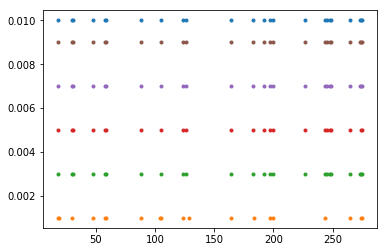

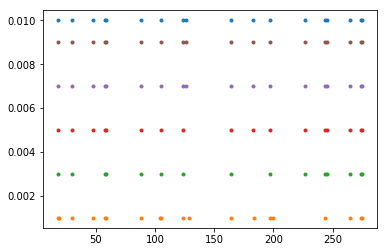

Sift_t: 23|[18, 30, 31, 48, 58, 59, 88, 105, 124, 126, 164, 183, 192, 197, 200, 227, 244, 245, 248, 249, 265, 274, 275]
Sift_std: 16|[18, 30, 48, 58, 59, 88, 105, 124, 164, 197, 227, 244, 245, 265, 274, 275]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-11


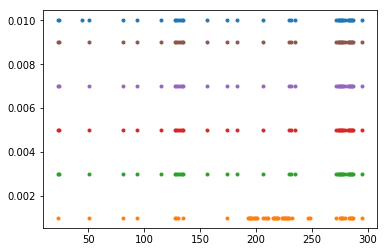

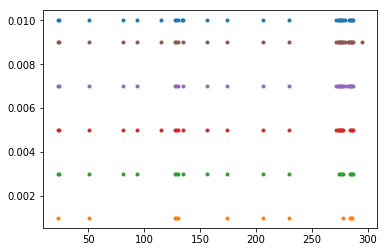

Sift_t: 34|[23, 24, 51, 81, 94, 115, 128, 129, 130, 132, 134, 135, 156, 174, 183, 206, 230, 231, 235, 272, 273, 274, 275, 276, 277, 278, 280, 282, 283, 284, 285, 286, 287, 295]
Sift_std: 21|[23, 24, 51, 81, 94, 128, 129, 130, 135, 156, 174, 206, 230, 274, 275, 277, 278, 284, 285, 286, 287]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-14-20


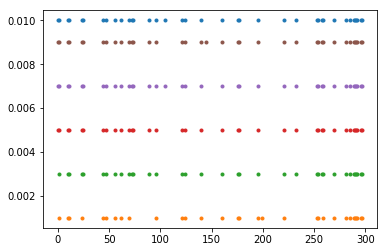

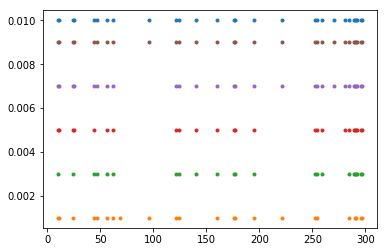

Sift_t: 36|[1, 10, 11, 24, 25, 44, 47, 56, 62, 69, 72, 73, 89, 96, 121, 124, 140, 160, 176, 177, 195, 221, 232, 253, 254, 258, 259, 270, 281, 285, 289, 290, 291, 292, 296, 297]
Sift_std: 24|[10, 11, 24, 44, 47, 56, 62, 121, 124, 140, 160, 176, 177, 195, 253, 254, 259, 285, 289, 290, 291, 292, 296, 297]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-15-21


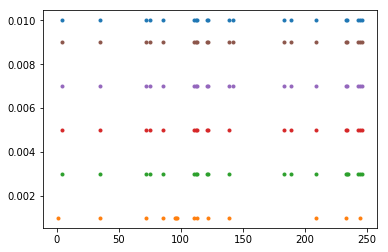

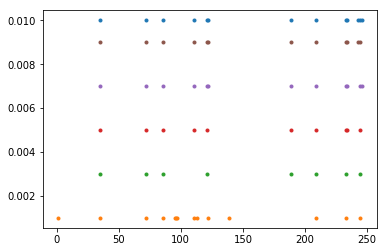

Sift_t: 19|[4, 35, 72, 75, 86, 111, 112, 113, 121, 122, 139, 183, 189, 209, 233, 234, 243, 244, 246]
Sift_std: 9|[35, 72, 86, 111, 121, 189, 209, 233, 244]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-16-21


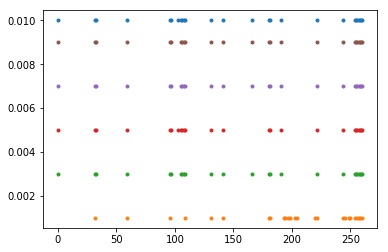

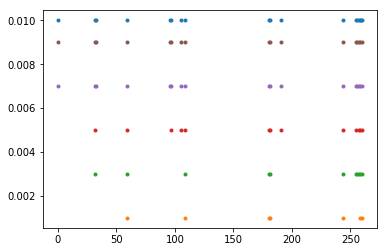

Sift_t: 24|[0, 32, 33, 59, 96, 97, 105, 106, 108, 109, 131, 141, 180, 181, 191, 221, 244, 254, 255, 256, 257, 258, 259, 260]
Sift_std: 10|[32, 59, 109, 180, 181, 244, 255, 257, 258, 260]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-17-20


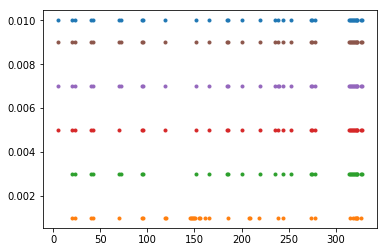

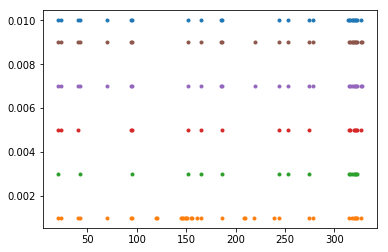

Sift_t: 33|[20, 23, 40, 42, 70, 94, 95, 119, 152, 165, 185, 186, 201, 220, 235, 239, 244, 253, 274, 275, 278, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 327, 328]
Sift_std: 20|[20, 23, 40, 42, 94, 95, 152, 165, 186, 244, 253, 274, 315, 316, 318, 320, 321, 322, 323, 327]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-18-19


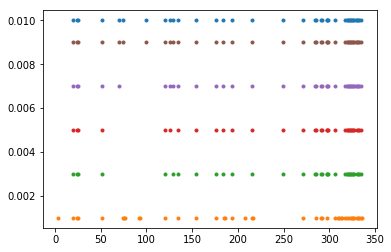

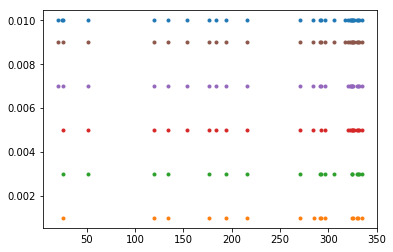

Sift_t: 34|[20, 24, 25, 51, 120, 134, 154, 176, 184, 194, 216, 249, 271, 284, 285, 291, 292, 297, 298, 299, 306, 317, 319, 320, 322, 323, 324, 325, 326, 327, 330, 331, 332, 335]
Sift_std: 18|[25, 51, 120, 134, 176, 194, 216, 271, 291, 292, 297, 324, 325, 326, 330, 331, 332, 335]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-21-20


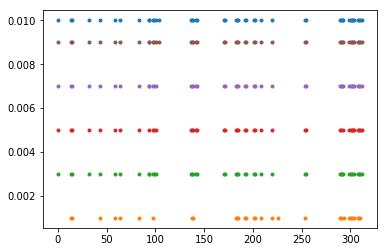

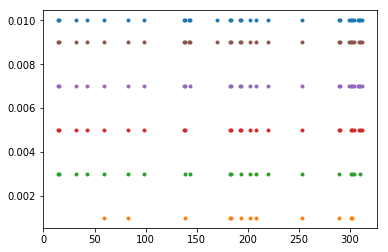

Sift_t: 41|[0, 14, 15, 32, 43, 59, 64, 83, 94, 98, 99, 101, 137, 138, 139, 142, 143, 170, 171, 183, 184, 185, 192, 193, 201, 202, 208, 220, 253, 254, 289, 290, 292, 299, 301, 302, 304, 308, 309, 310, 312]
Sift_std: 20|[14, 15, 32, 43, 59, 83, 98, 139, 183, 184, 193, 202, 208, 220, 253, 289, 301, 302, 304, 310]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-22-19


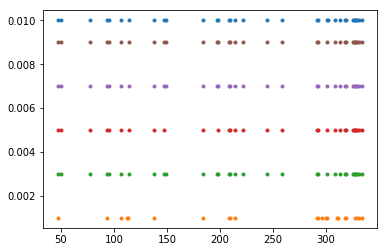

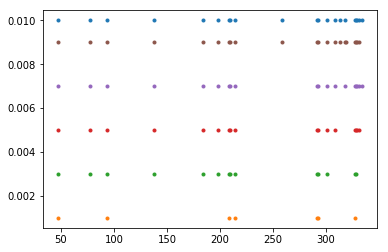

Sift_t: 31|[47, 50, 77, 93, 95, 107, 114, 138, 147, 184, 198, 208, 209, 214, 222, 244, 258, 291, 292, 301, 308, 313, 318, 319, 325, 326, 327, 328, 329, 331, 334]
Sift_std: 14|[47, 77, 93, 138, 184, 198, 208, 209, 214, 291, 292, 301, 327, 328]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-23-20


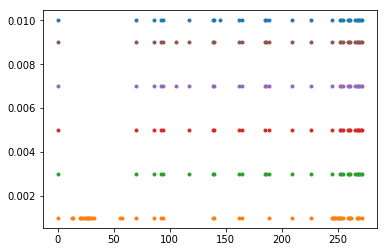

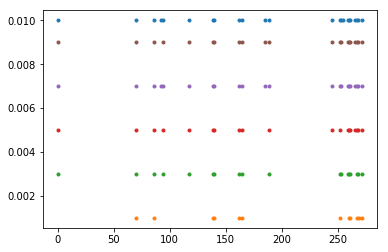

Sift_t: 27|[0, 70, 86, 92, 94, 117, 139, 140, 162, 165, 185, 189, 209, 226, 245, 252, 253, 255, 259, 260, 261, 266, 267, 268, 269, 271, 272]
Sift_std: 17|[0, 70, 86, 94, 117, 139, 140, 162, 165, 189, 252, 259, 260, 261, 267, 268, 272]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-24-19


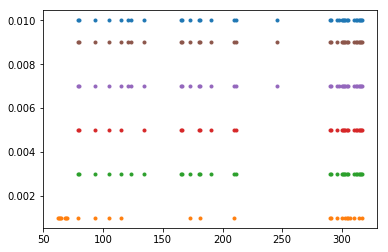

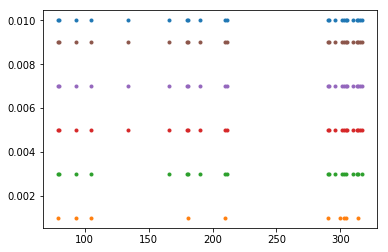

Sift_t: 30|[79, 80, 93, 105, 115, 134, 165, 166, 173, 180, 181, 190, 210, 211, 290, 291, 296, 300, 301, 302, 303, 304, 305, 310, 312, 313, 314, 315, 316, 317]
Sift_std: 20|[79, 80, 93, 105, 166, 180, 181, 190, 210, 211, 290, 291, 296, 301, 303, 304, 310, 313, 314, 317]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-27-22


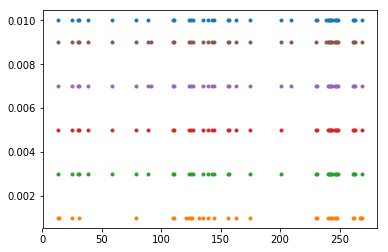

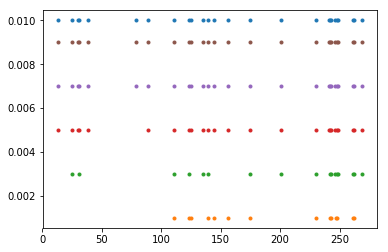

Sift_t: 37|[13, 25, 30, 31, 38, 59, 79, 89, 110, 111, 123, 125, 127, 135, 139, 143, 144, 156, 157, 163, 175, 201, 230, 231, 240, 241, 242, 243, 244, 246, 247, 248, 249, 261, 262, 263, 269]
Sift_std: 20|[25, 31, 111, 123, 125, 135, 139, 144, 156, 175, 201, 230, 242, 243, 246, 248, 249, 261, 262, 269]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-28-21


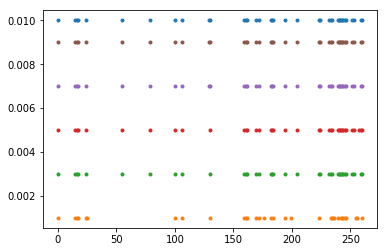

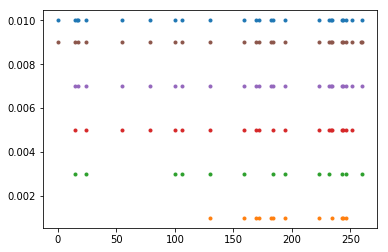

Sift_t: 37|[0, 15, 16, 17, 24, 55, 79, 100, 106, 130, 159, 161, 162, 169, 172, 182, 183, 184, 194, 204, 223, 224, 232, 233, 234, 239, 240, 241, 242, 243, 244, 245, 246, 251, 253, 259, 260]
Sift_std: 16|[15, 24, 100, 106, 130, 159, 169, 172, 184, 194, 223, 232, 234, 243, 244, 246]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-29-21


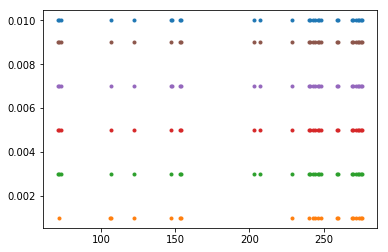

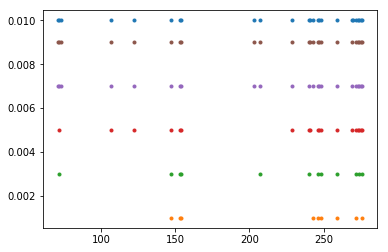

Sift_t: 27|[71, 72, 73, 107, 122, 147, 153, 154, 203, 207, 229, 240, 241, 243, 244, 246, 247, 248, 259, 260, 269, 270, 272, 273, 274, 275, 276]
Sift_std: 11|[72, 147, 153, 154, 240, 246, 248, 259, 272, 274, 276]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-04-30-20


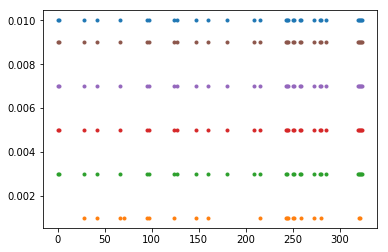

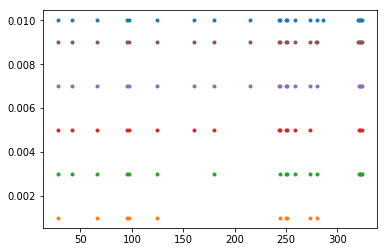

Sift_t: 30|[0, 1, 28, 42, 66, 95, 97, 124, 127, 147, 160, 180, 209, 215, 243, 244, 245, 250, 251, 258, 259, 273, 279, 280, 286, 320, 321, 322, 323, 324]
Sift_std: 16|[28, 42, 66, 95, 97, 124, 180, 244, 250, 251, 259, 273, 280, 321, 322, 324]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-05-01-20


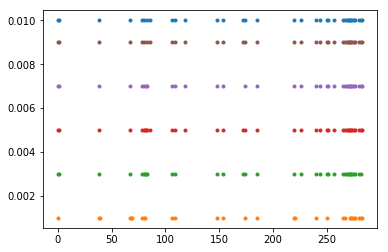

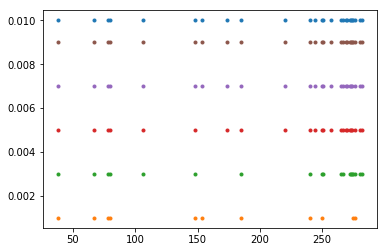

Sift_t: 33|[0, 1, 38, 67, 78, 80, 83, 106, 109, 148, 154, 174, 185, 220, 226, 240, 244, 250, 251, 257, 265, 267, 269, 270, 271, 272, 273, 274, 275, 276, 280, 282, 283]
Sift_std: 18|[38, 67, 78, 80, 106, 148, 185, 240, 250, 251, 265, 267, 272, 273, 274, 276, 280, 282]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-05-02-20


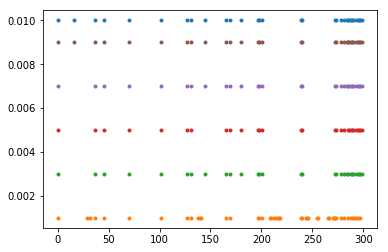

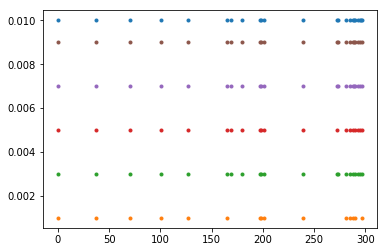

Sift_t: 28|[0, 37, 45, 70, 101, 127, 131, 165, 169, 180, 197, 198, 201, 239, 240, 272, 273, 278, 281, 285, 288, 289, 290, 293, 295, 296, 297, 299]
Sift_std: 20|[0, 37, 70, 101, 127, 165, 169, 180, 197, 198, 201, 239, 272, 281, 285, 288, 290, 293, 295, 297]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-05-04-20


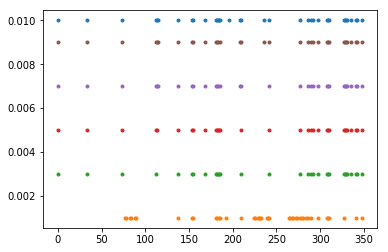

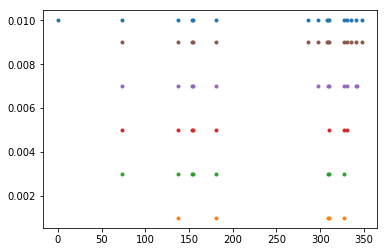

Sift_t: 30|[0, 33, 73, 112, 137, 154, 155, 168, 181, 182, 183, 186, 209, 241, 277, 286, 289, 292, 298, 308, 309, 310, 327, 328, 330, 331, 335, 341, 342, 348]
Sift_std: 8|[73, 137, 154, 155, 181, 309, 310, 327]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-05-05-21


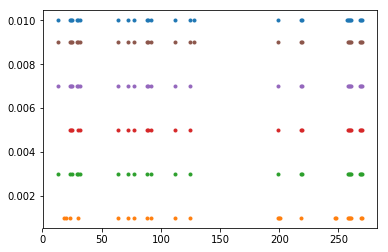

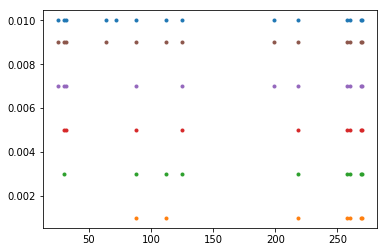

Sift_t: 21|[23, 25, 30, 32, 64, 72, 77, 88, 92, 112, 125, 199, 218, 219, 258, 259, 260, 261, 268, 269, 270]
Sift_std: 8|[30, 88, 125, 218, 258, 260, 269, 270]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-05-06-19


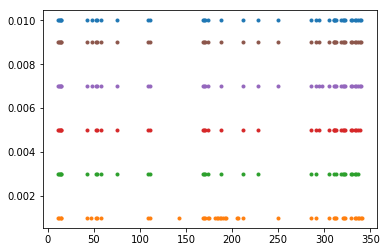

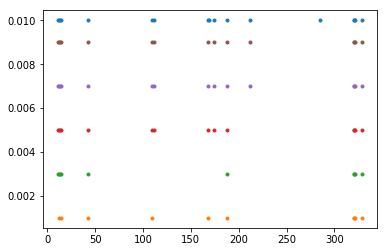

Sift_t: 34|[11, 12, 13, 14, 15, 43, 52, 53, 58, 75, 109, 111, 168, 169, 171, 174, 188, 212, 228, 285, 291, 305, 310, 312, 313, 318, 320, 321, 322, 329, 330, 333, 334, 337]
Sift_std: 12|[11, 12, 13, 14, 43, 109, 168, 188, 320, 321, 322, 329]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-05-07-20


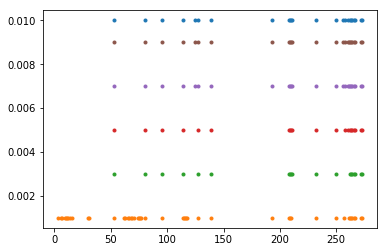

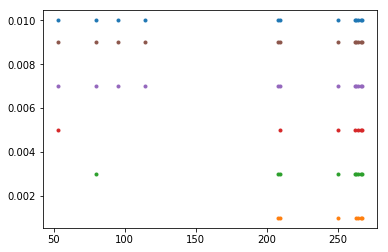

Sift_t: 19|[53, 80, 95, 114, 127, 139, 208, 209, 210, 211, 232, 250, 262, 263, 264, 266, 267, 272, 273]
Sift_std: 8|[208, 209, 250, 262, 263, 264, 266, 267]

FILE PATH: /Volumes/NO NAME/sleeper/photos_processed/2019-05-08-21


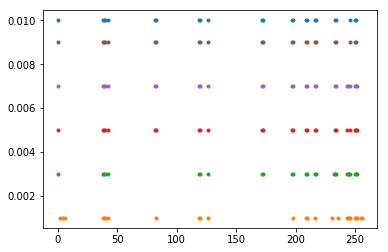

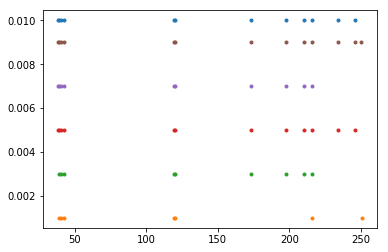

Sift_t: 22|[0, 38, 39, 40, 42, 83, 119, 120, 126, 172, 173, 197, 198, 209, 210, 216, 217, 233, 234, 246, 250, 251]
Sift_std: 9|[39, 40, 42, 119, 120, 173, 198, 210, 216]



,folder_name,duration,count_t_frames,t_frames_list,count_std_frames,std_frames_list
0,2019-02-18,248,25,"[0, 1, 2, 19, 26, 42, 50, 58, 72, 95, 110, 118...",21,"[1, 19, 26, 42, 50, 58, 72, 95, 110, 162, 163,..."
1,2019-02-20,248,23,"[0, 56, 57, 60, 83, 119, 120, 182, 183, 184, 1...",9,"[119, 120, 182, 220, 225, 226, 227, 228, 245]"
2,2019-02-21,216,21,"[16, 68, 74, 75, 94, 101, 119, 157, 176, 183, ...",16,"[16, 68, 74, 75, 94, 101, 119, 157, 176, 183, ..."
3,2019-02-22,243,20,"[0, 35, 53, 59, 111, 112, 121, 122, 124, 145, ...",14,"[0, 35, 59, 112, 121, 122, 145, 186, 203, 206,..."
4,2019-02-25,304,31,"[0, 49, 50, 79, 98, 113, 116, 154, 156, 163, 1...",20,"[49, 50, 79, 98, 154, 163, 174, 175, 212, 266,..."
5,2019-02-26,276,29,"[20, 21, 22, 23, 66, 67, 76, 89, 90, 95, 118, ...",18,"[21, 67, 76, 89, 90, 158, 175, 177, 215, 216, ..."
6,2019-02-27,328,26,"[0, 12, 60, 93, 109, 139, 148, 165, 187, 260, ...",19,"[0, 60, 93, 109, 139, 165, 260, 261, 299, 306,..."
7,2019-02-28,236,17,"[71, 72, 98, 135, 162, 198, 199, 212, 213, 214...",15,"[71, 98, 135, 162, 198, 199, 212, 213, 214, 22..."
8,2019-03-01,277,29,"[16, 44, 67, 71, 92, 101, 115, 151, 190, 195, ...",25,"[16, 44, 92, 101, 115, 151, 190, 195, 209, 211..."
9,2019-03-03,303,44,"[12, 21, 22, 33, 50, 52, 67, 76, 81, 90, 91, 9...",20,"[50, 81, 90, 97, 153, 181, 184, 193, 195, 221,..."


In [3]:
import pathlib
import os
import pandas as pd

dirpath = '/Volumes/NO NAME/sleeper/photos_processed/'
p = pathlib.Path(dirpath)
folders_list = ([x for x in sorted(p.iterdir()) if x.is_dir()])

record = pd.DataFrame(columns=['folder_name', 'duration',
                              'count_t_frames', 't_frames_list',
                               'count_std_frames', 'std_frames_list'])

pr = ImageGrammarProcessor()

for f in folders_list:
    t_frames_list, std_frames_list = pr.get_sift_frames(f, verbose=0)

    folders_list = sorted(pathlib.Path(f).iterdir())
    first_file_int = get_index_of_file(f, 0)
    last_file_int = get_index_of_file(f, -1)
    duration = last_file_int - first_file_int
    
    record = record.append({'folder_name': f.stem,
                            'duration': duration,
                            'count_t_frames': len(t_frames_list),
                            't_frames_list': t_frames_list,
                            'count_std_frames': len(std_frames_list),
                            'std_frames_list': std_frames_list},
                           ignore_index=True)

display(record)
record.to_csv('/Volumes/NO NAME/sleeper/record.csv')